In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.insert(0, './')
from functions import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Identify Vulnerable Tracts


In [2]:
df = pd.read_parquet('Data/Cleaned/after_kriging.parquet')


In [3]:
# TODO: figure out if dollar amounts in ACS are inflation adjusted or not

def find_vulnerable_tracts(df, year):
    
    # limit df to date provided
    df_yr = df[df.year==year]
    threshold_white = df_yr.percent_white.quantile(.6)
    threshold_income = df_yr.med_income.quantile(.6)
    
    # define eligible column if tract meets all criteria
    df_yr['vulnerable'] = np.where(
                            (df_yr.med_income <= threshold_income) &
                              (df_yr.percent_white <= threshold_white), 1, 0)
    vulnerable_tracts = df_yr[df_yr['vulnerable']==1]['full_tract'].unique()

    return df_yr


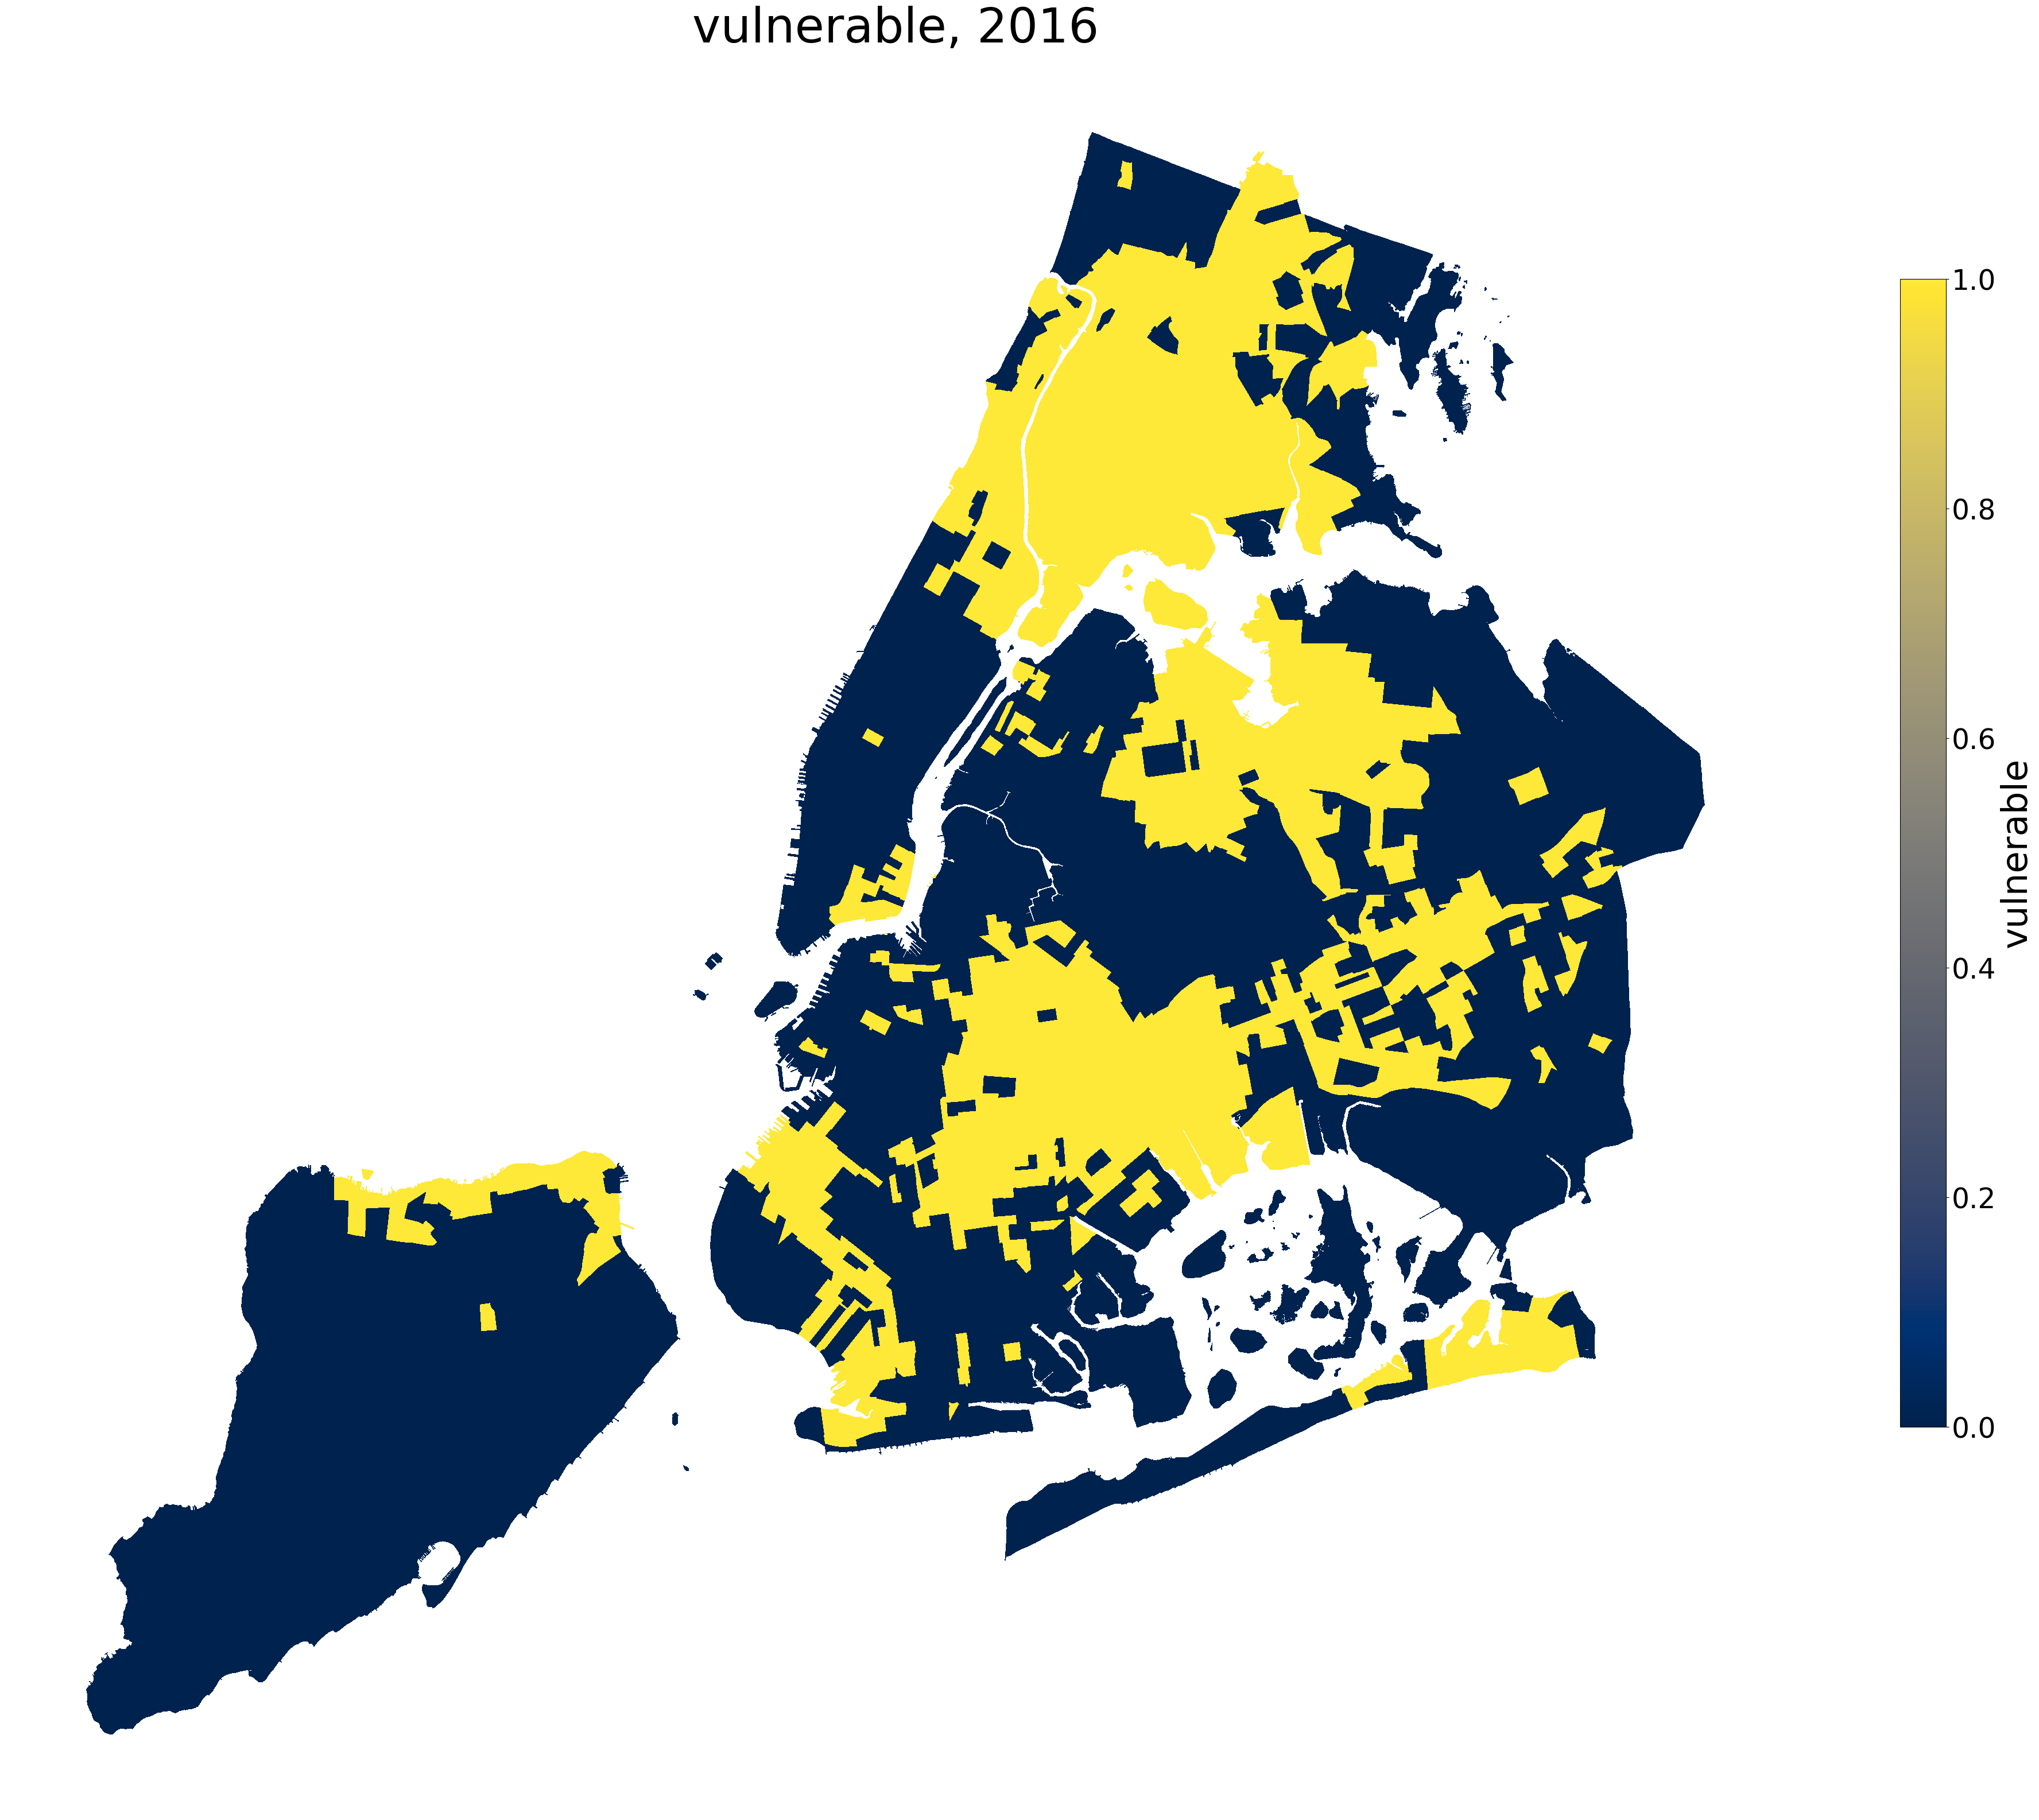

In [113]:
# Test out the function

df_16 = find_vulnerable_tracts(df, '2016')
choropleth(df_16, 'vulnerable', ['2016'], cmap='cividis')


# Identify Gentrified Tracts
We look at percent changes in decade prior to datestamp


In [4]:
def find_gentrified_tracts(df, pred_year):
    df = df[df.year.astype(int) >= int(pred_year)-10]  # limit df to the 10 years prior
    
    # fill zeros with nan so we can calculate percent change
    df.replace(0, np.nan, inplace=True)
    
    # get average percent change over decade
    pct_chg = df.drop(['NAME','year','full_tract', 'vulnerable'], axis=1).groupby('GEOID').agg(lambda x: x.pct_change().mean())
    pct_chg.dropna(how='all', inplace=True)
    pct_chg.fillna(0, inplace=True)

    # Set thresholds. consider it gentrifying if % change is greater than median for region (of all tracts, not just vulnerable ones)

    # # Median White
    # threshold_white = pct_chg.percent_white.quantile(.5)

    # Median Bachelors
    threshold_bach = pct_chg.percent_grad.quantile(.5)

    # Median HH Median Income
    threshold_income = pct_chg.med_income.quantile(.5)

    # define gentrified column if tract meets all criteria
    pct_chg['gentrified'] = np.where(
                                 (pct_chg.percent_grad>=threshold_bach)&
                                 (pct_chg.med_income>=threshold_income), 1, 0)  # 1 is gentrified, 0 is not
    
    return(pct_chg[['gentrified']].reset_index())
    

## Corroborate labels with UDP 2016

In [134]:
# labels_16 = pd.read_excel("Data/Raw/udp_labels_2016.xlsx")
# df_16 = find_vulnerable_tracts(df, '2016')

In [135]:

# labels_16['udp_labels'] = np.select([labels_16['Type_1.19'].isin(['LI - At Risk of Gentrification',
#                                    'LI - Ongoing Gentrification']),
#                                         labels_16['Type_1.19'].isin(['LI - Ongoing Displacement of Low-Income Households',
#        'LI - Not Losing Low-Income Households']),
#                                         labels_16['Type_1.19'].isin(['MHI - Advanced Gentrification',
#        'MHI - Ongoing Exclusion', 'MHI - Stable Exclusion',
#        'Missing Data', 'VHI - Super Gentrification or Exclusion'])],
#                                         [2,1,0], 
#                                         -1)
# labels_16['geoid'] = labels_16['geoid'].astype(str)
# udp_df = df_16.merge(labels_16, left_on='GEOID', right_on='geoid')


In [136]:
# choropleth(udp_df, 'udp_labels', ['2016'], cmap='plasma')

# Construct Labels For Training
- train on features 2010-2016 to predict gentrification status in 2020 (labels from 2020, eligible tracts from 2010)
- train on features 2013-2019 to predict gentrification status in 2023 (labels from 2023, eligible tracts from 2013)

- then use features 2017-2023 to predict gentrification status in 2027 (no labels, eligible tracts are taken from 2017)


In [5]:
def construct_labels(df, yr_vulnerable, yr_gentrified, pred_set=False):
    temp_df = df.copy()
    
    # Identify Vulnerable Tracts
    vul_tracts_df = find_vulnerable_tracts(temp_df, yr_vulnerable)
    vul_tracts = vul_tracts_df[vul_tracts_df['vulnerable']==1]['full_tract']
    temp_df['vulnerable'] = np.where(temp_df.full_tract.isin(vul_tracts), 1,0)

    if not pred_set:
        # Identify Gentrified Tracts (has to be a vulnerable tract)
        gent_tracts_df = find_gentrified_tracts(temp_df, yr_gentrified)
        gent_tracts = gent_tracts_df[gent_tracts_df['gentrified']==1]['GEOID']
        temp_df['gentrified'] = np.where((temp_df.GEOID.isin(gent_tracts)), 1,0)
    else:
        temp_df['gentrified'] = 0

    # Create label based on vulnerable and gentrified tracts
    temp_df['label'] = np.select([((temp_df['gentrified']==1) & (temp_df['vulnerable']==1)),  # gentrified if also vulnerable
                                  (temp_df['vulnerable']==0),  # if not vulnerable it cannot be gentrified
                                  ((temp_df['gentrified']==0) & (temp_df['vulnerable']==1))],  # can be vulnerable but not gentrified
                      [2,0,1],
                      -1)
    temp_df['pred_year'] = yr_gentrified
    return temp_df

In [6]:
labels_2020 = construct_labels(df, '2010','2020')
labels_2021 = construct_labels(df, '2011','2021')
labels_2022 = construct_labels(df, '2012','2022')
labels_2023 = construct_labels(df, '2013','2023')
labels_2027 = construct_labels(df, '2017','2027', pred_set=True)  # get vulnerable tracts for the pred set
labels = pd.concat([labels_2020,labels_2021,labels_2022, labels_2023, labels_2027])

labels_2023.label.value_counts()


label
0    17682
1     8806
2     6062
Name: count, dtype: int64

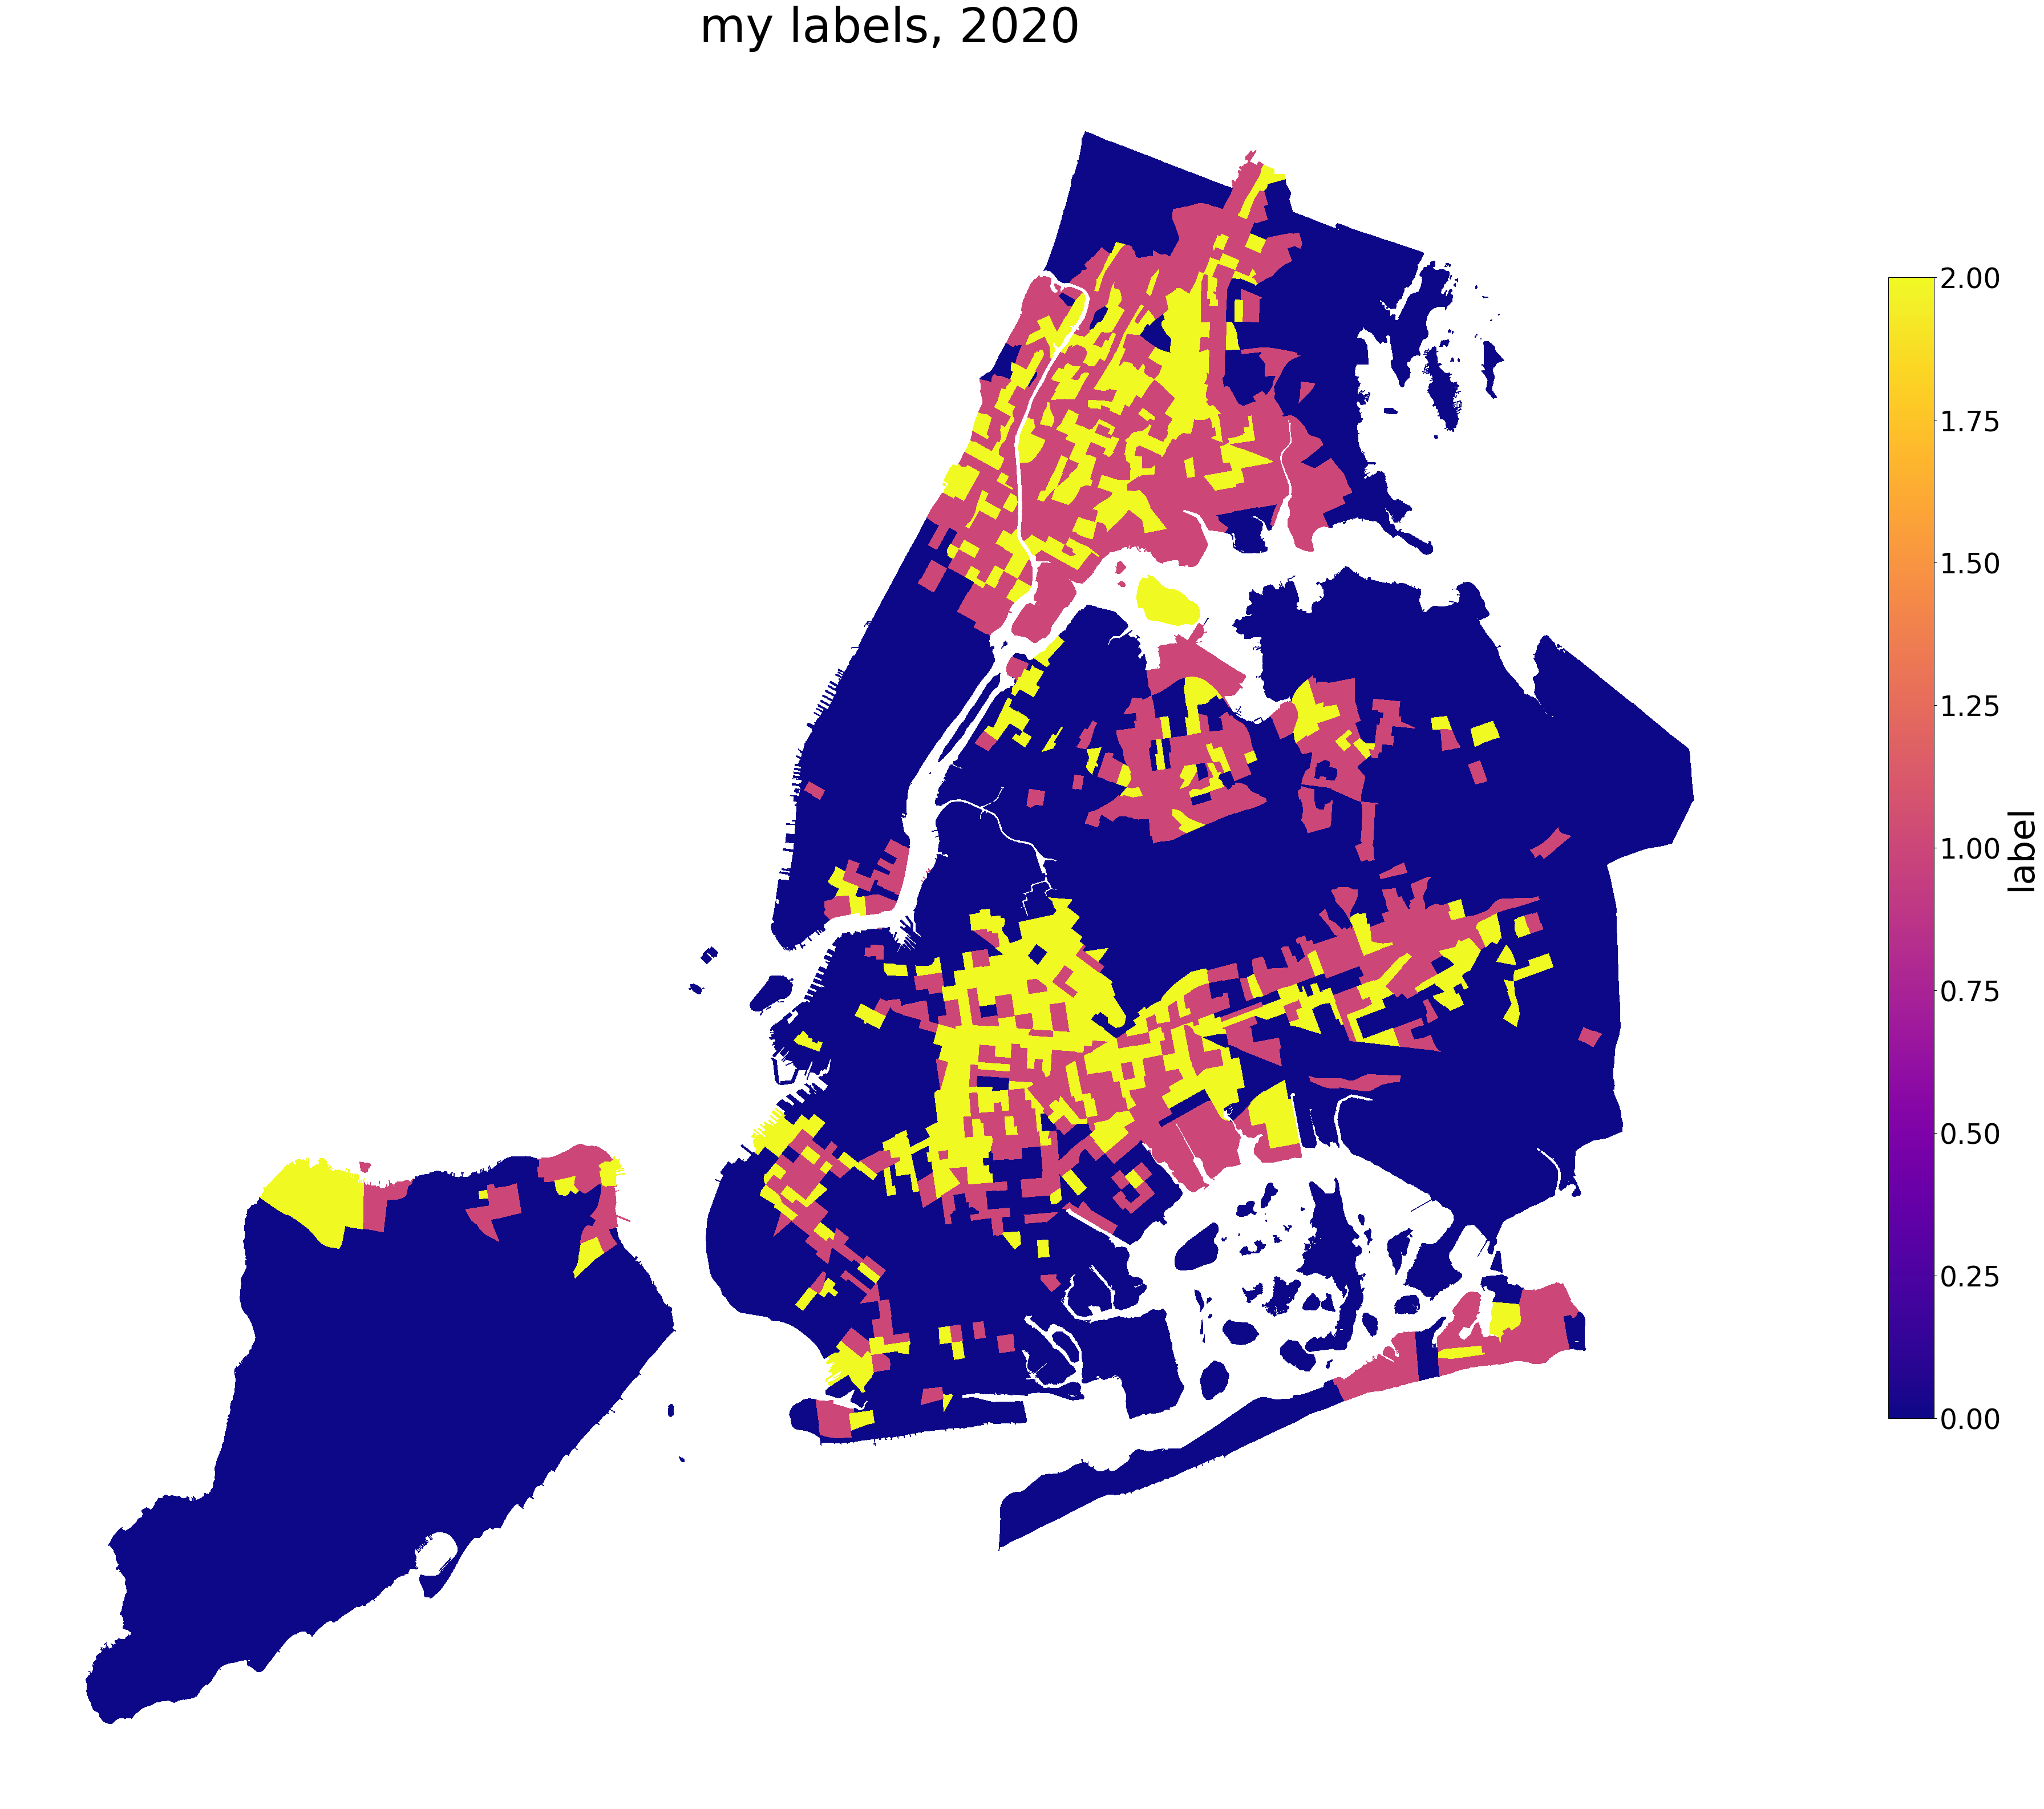

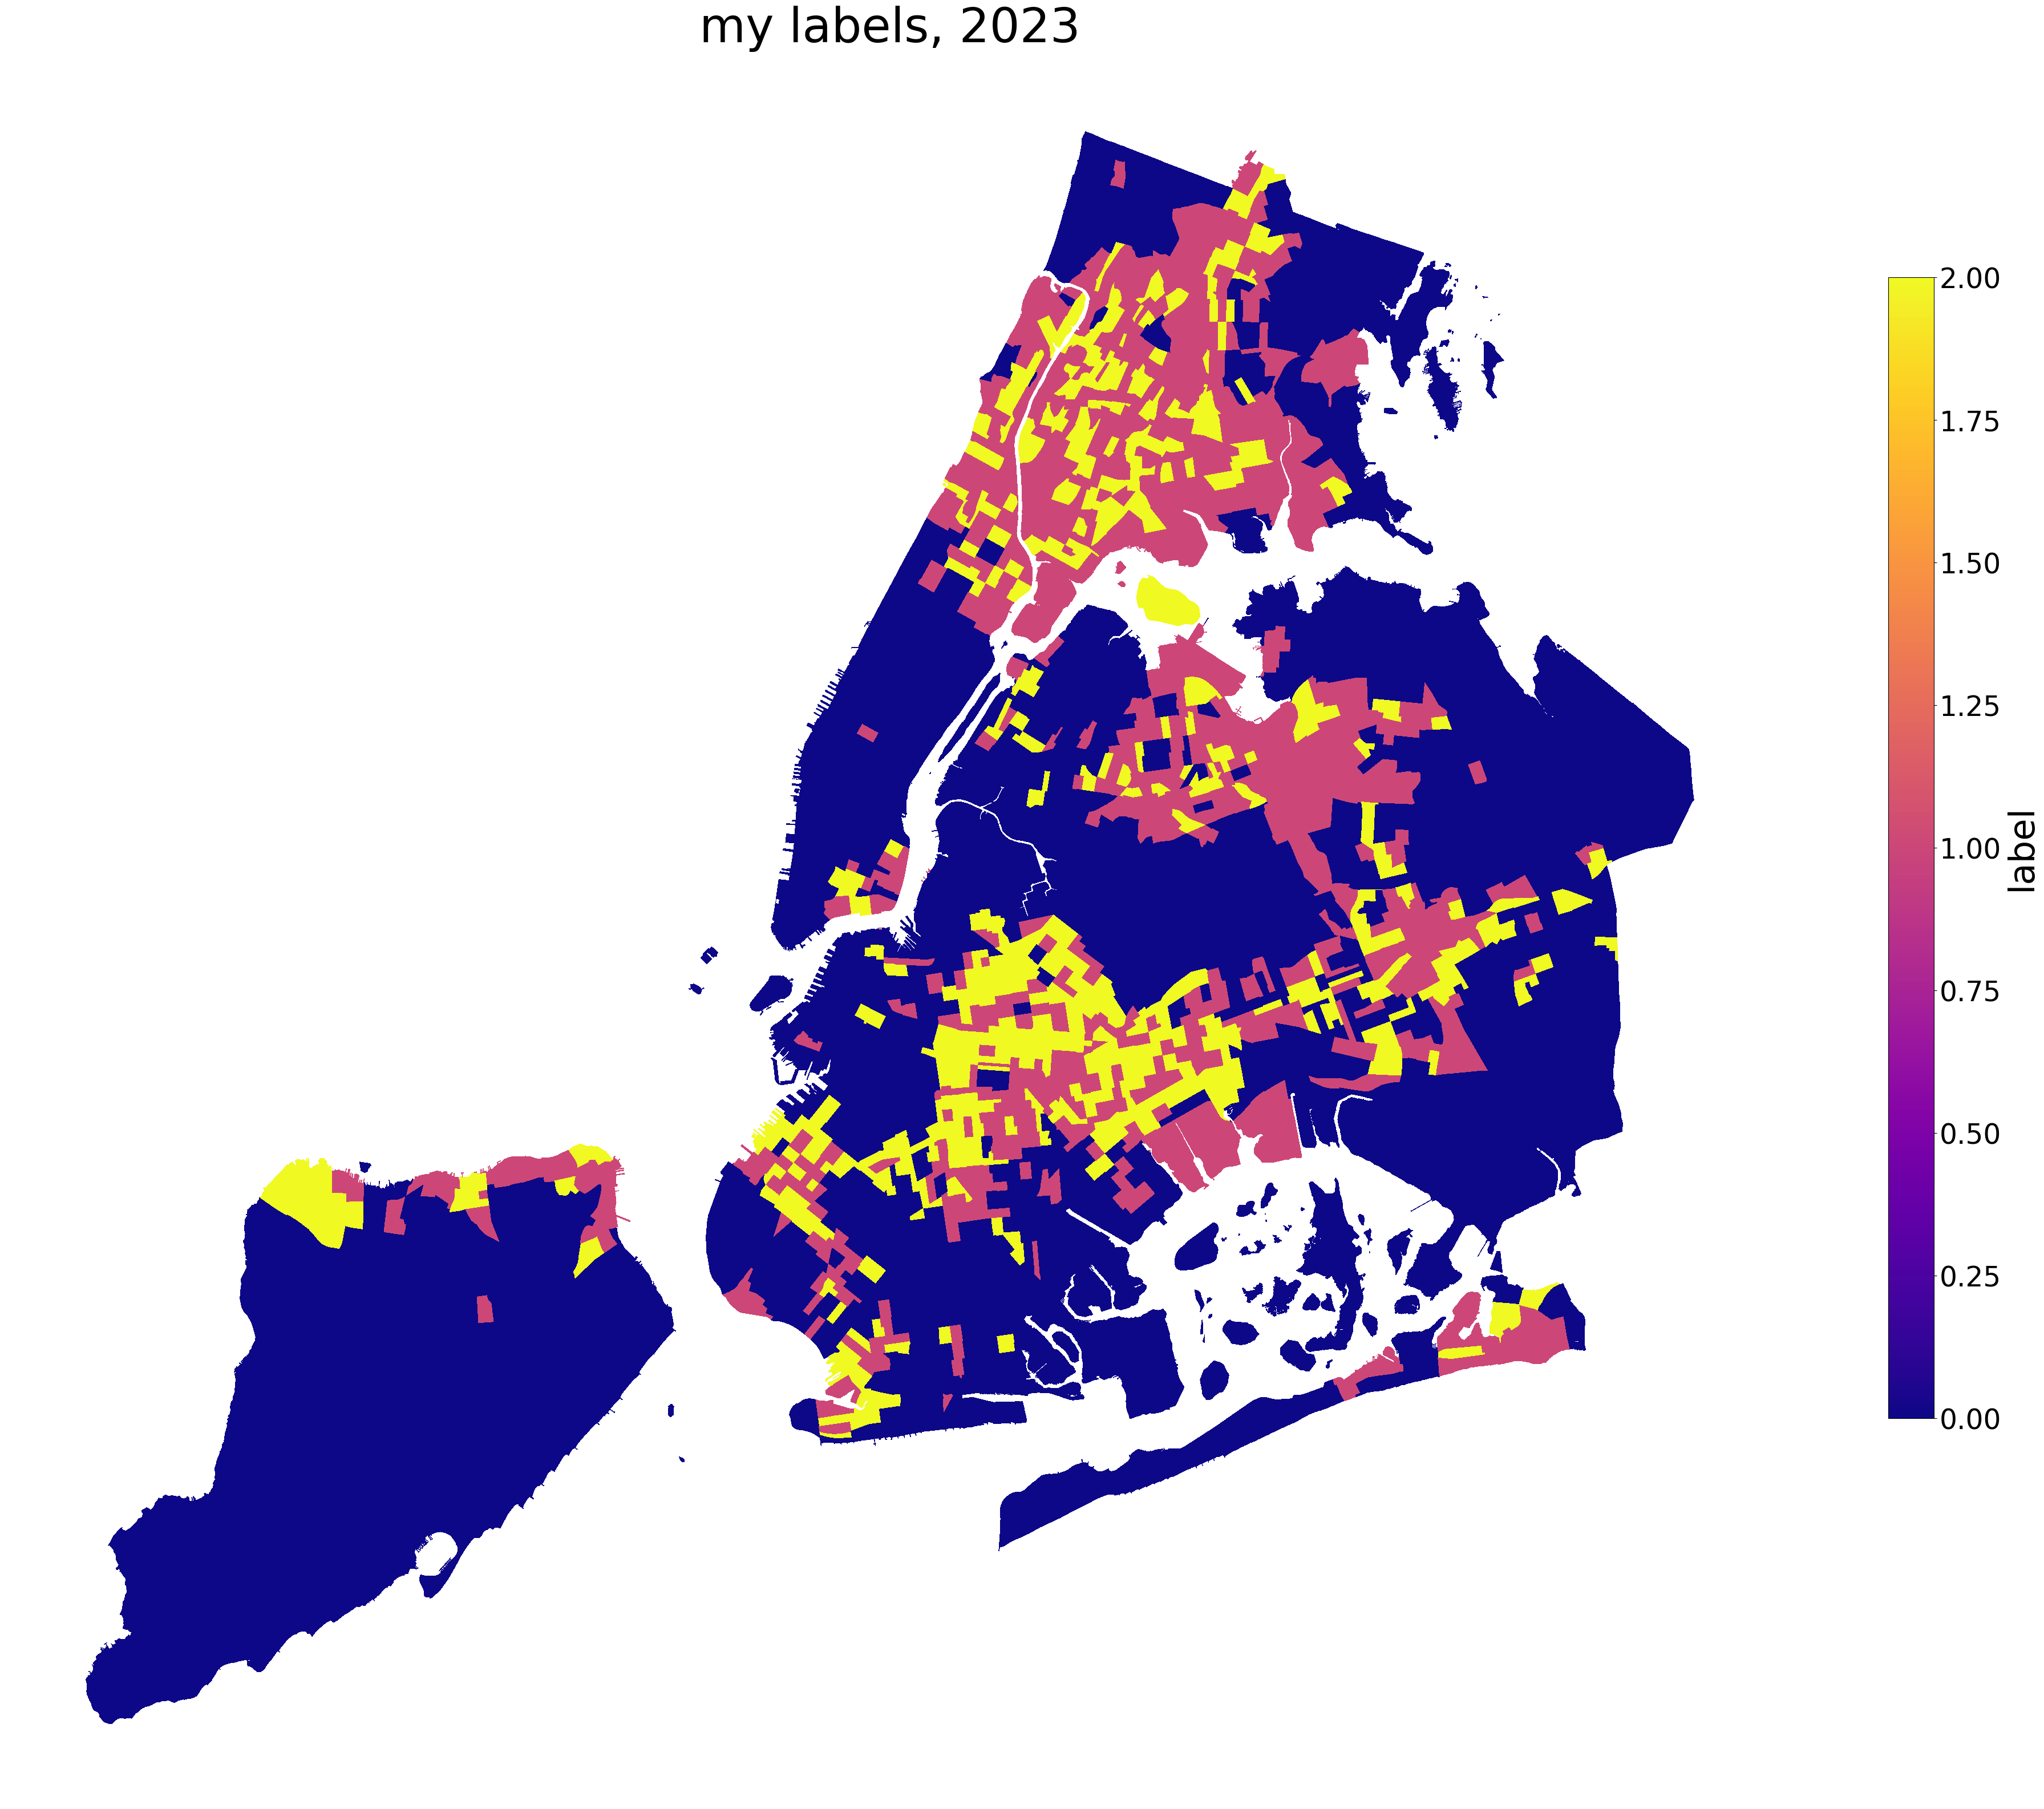

In [141]:
choropleth(labels_2020, 'label', ['2020'], cmap='plasma', title='my labels')
choropleth(labels_2023, 'label', ['2023'], cmap='plasma', title='my labels')
# choropleth(labels_2027, 'label', ['2017'], cmap='plasma', title='my labels')

In [7]:
# to_save = labels[['GEOID','label','vulnerable','gentrified','pred_year']].drop_duplicates()
# to_save.to_parquet('Data/Cleaned/more_labels.parquet')
